In [1]:
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.utils import class_weight



Using TensorFlow backend.


# Import data

In [9]:
# Store the input data in a dataframe
fraud_data = pd.read_csv("creditcard.csv")


# Preprocess data

In [43]:
# shuffle the dataframe so that the inputs are in a random order
df = fraud_data.sample(frac=1).reset_index(drop=True)

# Scale the time between -1 and 1, since the rest of the features are scaled
robust_scaler = RobustScaler()
scaled_time = robust_scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time'], axis=1, inplace=True) #  Remove unscalled time

# Insert scalded time into beginning of df
df.insert(0, 'scaled_time', scaled_time)

# Show the result
df.head()


,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.436119,1.659400,0.030687,0.216035,3.931988,-0.282385,0.499405,-0.373986,0.096752,-0.461964,...,0.262464,0.659620,0.169421,1.154898,-0.268064,-0.044211,0.000158,-0.000761,104.26,0
1,0.744757,-0.705866,0.751561,1.107973,0.160060,-0.744155,0.256062,-0.518433,0.488345,1.729342,...,-0.189143,0.216038,-0.005518,-0.121670,-0.593673,0.559921,0.080099,-0.050877,12.72,0
2,0.310365,2.102723,-0.064331,-1.465900,0.340946,0.233706,-0.762994,-0.066726,-0.245579,2.353592,...,0.072891,0.511258,0.014242,0.382284,0.300290,-0.468796,-0.036342,-0.060379,1.00,0
3,-0.006532,-0.452415,-0.975171,1.860540,-1.234296,-0.917268,-1.012777,-0.926766,-0.001787,-2.302606,...,-0.211618,-0.497652,0.240393,0.313328,-0.586195,-0.319509,0.143384,0.157308,31.00,0
4,0.688236,-0.304870,0.937227,-0.488325,-0.630074,1.279189,-0.786910,1.125149,-0.369006,0.342341,...,-0.455419,-0.814172,0.244162,0.374622,-0.310943,0.099776,0.087707,-0.114391,1.98,0


In [154]:
# Split the data into training (80%) and testing (20%)
train, test = train_test_split(df, test_size=0.2)

# Split data into features and labels (only using the first 29 columns as 30 is the amount and 31 is the label
train_features = np.array(train.values[:,:29])
train_labels = np.array(train.values[:,-1])
test_features = np.array(test.values[:,:29])
test_labels = np.array(test.values[:,-1])
train_amounts = np.array(train.values[:,-2])
test_amounts = np.array(test.values[:,-2])



# Create our custom loss fxn for cost sensitive learning

The code was adapted from https://github.com/roman807/Fraud-Detection Nov 28th, 2019

Keras only allows does not allow any other arguments except for the true and predicted labels to be passed into the loss
function.

As such, we adapted roman807s code to pass in the value of each transaction for each sample as a string. The label is
passed in before the decimal, and the cost of a false negative is passed in after the decimal. 

The custom loss function is wrapped in another function that takes the cost of a false positive, true positive, true 
negative. The cost is calculated by applying the cost of the fn, tn, fp, tp. The variables below are the ones that
provided the best performance. There is no penalty for predicting correctly. The penalty for falsely predicting positively
is "13", and falsely predicting negative is the transaction amount, as that is how much that would be lost.   

In [121]:
cost_FN = train_amounts
cost_FP = 13
cost_TP = 0
cost_TN = 0

# Create y Input from roman807
def create_y_input(y_label, cost_fn):
    label_string = pd.Series(y_label).reset_index(drop=True).apply(lambda x: str(int(x)))
    cost_fn_string = pd.Series(cost_fn).reset_index(drop=True).apply(lambda x: '0' *
                        (5-len(str(int(x)))) + str(int(x)))
    return label_string + '.' + cost_fn_string

# custom loss adapted from roman807
def custom_loss(c_FP, c_TP, c_TN):
    def loss_function(y_input, y_pred):
        min = 0.0001
        
        # Calculate the true value by removing the decimals from the y input string created earlier
        y_true = K.round(y_input)
        
        # Extract the false negative cost from the y input string created earlier
        cost_fn = (y_input - y_true) * 1e6
        
        # Calculate predicted value, making sure it does not equal 0 or 1
        y_pred = K.minimum(1.0 - min, K.maximum(0.0 + min, y_pred))
        
        # Calculate the cost of the prediction from the cost of misclassified defined earlier
        cost_fn = y_true * (K.log(y_pred) * cost_fn)
        cost_tp =  y_true * (K.log(1 - y_pred) * c_TP)
        cost_fp = (1 - y_true) * (K.log(1 - y_pred) * c_FP)
        cost_tn = (1 - y_true) * (K.log(y_pred) * c_TN)
        total_cost = cost_fn + cost_tp + cost_fp + cost_tn
        return - K.mean(total_cost, axis=-1)
    return loss_function

# Set how much we care about each mis-classification data

In [122]:
# Because the set is highly imbalanced, we weight the minority set more than the majority set when misclassified
class_weights = class_weight.compute_class_weight("balanced", np.unique(train_labels), train_labels)


# Create the model

In [191]:
model = Sequential()
model.add(Dense(units=100, kernel_initializer='uniform', input_dim=train_features.shape[1], activation='relu'))
model.add(Dropout(.2))
model.add(Dense(units=100, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(.2))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

model.compile(optimizer='adam', metrics=['accuracy'], loss=custom_loss(cost_FP, cost_TP, cost_TN))


# Train the model

In [192]:
# Create our custom input labels to pass to keras with the cost of a false negative 
y_input = create_y_input(train_labels, cost_FN).apply(float)
train_history = model.fit(train_features, y_input, batch_size=50, epochs=25, verbose=1, validation_split=0.2, class_weight=class_weights)




Train on 182276 samples, validate on 45569 samples
Epoch 1/25
182276/182276 [==============================] - 7s 39us/step - loss: 3.2461 - accuracy: 0.0585 - val_loss: 1.0797 - val_accuracy: 0.0610
Epoch 2/25
182276/182276 [==============================] - 7s 37us/step - loss: 1.6899 - accuracy: 0.0584 - val_loss: 2.2927 - val_accuracy: 0.0610
Epoch 3/25
182276/182276 [==============================] - 6s 35us/step - loss: 1.5296 - accuracy: 0.0585 - val_loss: 2.6269 - val_accuracy: 0.0610
Epoch 4/25
182276/182276 [==============================] - 6s 35us/step - loss: 2.4740 - accuracy: 0.0584 - val_loss: 2.4305 - val_accuracy: 0.0610
Epoch 5/25
182276/182276 [==============================] - 7s 36us/step - loss: 1.4202 - accuracy: 0.0584 - val_loss: 2.2364 - val_accuracy: 0.0610
Epoch 6/25
182276/182276 [==============================] - 6s 35us/step - loss: 1.2531 - accuracy: 0.0585 - val_loss: 1.1378 - val_accuracy: 0.0610
Epoch 7/25
182276/182276 [=============================

In [193]:

# Get model accuracy 
scores = model.evaluate(test_features, test_labels)
print('\n')
print('accuracy=',scores[1])

# Get predictions from model
output = model.predict_classes(test_features)

# Show confusion matrix
y_actu = pd.Series(test_labels, name='Actual')
y_pred = pd.Series(np.ndarray.flatten(output), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

num_positives =  (np.count_nonzero(y_actu))
num_negatives = y_actu.size - num_positives

TN = df_confusion[0][0]
TP = df_confusion[1][1]
FN = df_confusion[0][1]
FP = df_confusion[1][0]

precision = TP/(TP + FP)
recall = TP/(TP + FN)
specificity = TN/(TN + FP)
f1 = 2*((precision*recall)/(precision+recall))
print("Num Fraud: {}".format(num_positives))

print("Precision: ", precision)
print("Recall/Sensitivity: ", recall)
print("Specificity: ", specificity)
print("F1 Score: ", f1)

# Get incorrctly predicted
indices = [i for i,v in enumerate(output) if output[i]!=test_labels[i] and output[i] == 0]
incorrect = [test_amounts[i] for i in indices ]
print("Individual cost of false negatives:\n{}".format(incorrect))


56962/56962 [==============================] - 1s 16us/step


accuracy= 0.9982970952987671
Predicted      0   1
Actual              
0.0        56779  79
1.0           18  86
Num Fraud: 104
Precision:  0.5212121212121212
Recall/Sensitivity:  0.8269230769230769
Specificity:  0.9986105737099441
F1 Score:  0.6394052044609665
Individual cost of false negatives:
[1.0, 0.76, 30.14, 357.95, 7.06, 0.0, 22.04, 1.0, 2.0, 1.0, 19.95, 3.14, 1.0, 33.76, 323.77, 1.0, 1.52, 23.36]


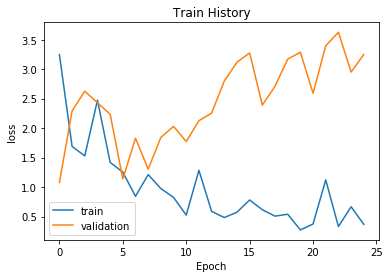

AUC: 0.98


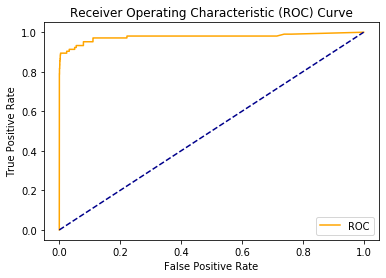

In [194]:
# Function to graph training history
def show_train_history(train_history,train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

show_train_history(train_history,'loss', 'val_loss')


def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

probs = model.predict_proba(test_features)
auc = roc_auc_score(test_labels, probs)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(test_labels, probs)
plot_roc_curve(fpr, tpr)
